#### Apo Challenge

## Random Forest

In this notebook, hyperparameters for a random forest are tuned.
The baseline random forest was the most promising model (see BaselineModels.ipynb).

In [35]:
#! pip install nbimporter
import nbimporter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, auc, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, plot_roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
import nbimporter
#For upsampling data
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tqdm import tqdm
#!pip install pickle-mixin
import pickle

In [36]:
import Stored_Functions
from Stored_Functions import preprocessing, plot_roc_curve, define_thresholds

In [27]:
#OPTIONAL
#Disable scientific notation for floats
pd.options.display.float_format = '{:,}'.format

In [28]:
#Load training data
X_train = pd.read_json('train_preprocessed.json').drop('zielvariable', axis = 1)
y_train =  pd.read_json('train_preprocessed.json').zielvariable

In [29]:
#Load validation data
X_val = pd.read_json('validation_preprocessed.json').drop('zielvariable', axis = 1)
y_val =  pd.read_json('validation_preprocessed.json').zielvariable

In [33]:
corr_features = ['monat', 'dauer', 'alter', 'kontostand', 'haus', 'kredit', 'tage_seit_letzter_kampagne','letzte_kampagne', 'erwerbstaetigkeit']

In [39]:
#Preprocssing: Rescale numeric data, encode categorical data and make a list with feature names (needed for feature importancce)
def preprocessing(X_train, X_val, y_train, y_val, train_only = False):
    '''Function to rescale numeric data and encode categorical data of train dataframe and optionally, validation data.
    Training data is additionally upsampled using SMOTENC
    Input:
    X_train: training features as pd.DataFrame
    y_train: training target as pd.DataFrame
    X_val: validation features as pd.DataFrame
    y_val: validation target as pd.DataFrame
    train_only: Bool, if False, training and validation are to be transformed, if True, only training data is transformed'''
    
    #List of categorical features
    cat = list(X_train.select_dtypes('object'))
    
    #Indices of categorical data
    cat_indices = []
    for col in cat:
        cat_indices.append(X_train.columns.get_loc(col))

    #numerical features
    num = list(X_train.select_dtypes('number')) 
    
    #Pipeline for feature transformation: rescale numerical features, numerically encode categorical features
    preprocessor = ColumnTransformer([
        ('scale_numceric', RobustScaler(), num),
        ('encode_cat', OneHotEncoder(drop = 'first'), cat)], 
        remainder = 'passthrough')
    
    #fit to train data
    preprocessor.fit(X_train)
    
    #transform train data
    X_train = pd.DataFrame(preprocessor.transform(X_train))
    y_train = pd.get_dummies(y_train, drop_first = True)
    
    #get features names 
    feature_names = num + list(preprocessor.named_transformers_['encode_cat'].get_feature_names())
    
    #Oversampling train data via smotenc 
    X_sm, y_sm = SMOTENC(categorical_features = cat_indices, random_state = 42, sampling_strategy = 'minority', n_jobs = -1).fit_sample(X_train, y_train)
    
    if train_only == True:
        return np.array(X_sm), np.array(y_sm), feature_names
    else:
        #transform validation data
        X_val = pd.DataFrame(preprocessor.transform(X_val))
        y_val = pd.get_dummies(y_val, drop_first = True)
        return np.array(X_sm), np.array(X_val), np.array(y_sm), np.array(y_val), feature_names

In [41]:
#Use preprocessing function (see BaselineModels.ipynb)
X_train, X_val, y_train, y_val, feature_names = preprocessing(X_train[corr_features], X_val[corr_features], y_train, y_val, train_only = False)

In [42]:
#Randomized Search
params_rf = {
    'n_estimators': list(range(100, 2001, 10)),
    'max_features': ['auto', 'sqrt'],
    'max_depth': list(range(5, 101, 5)),
    'min_samples_split': list(range(2, 52, 2)),
    'bootstrap': [True, False], 
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 5, 1: 1}, 'balanced'],
    'criterion': ['gini', 'entropy']
}

In [ ]:
search = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1, random_state = 42), params_rf, cv = 3, n_iter = 100, scoring = 'roc_auc')
search.fit(X_train, y_train.ravel())

exception calling callback for <Future at 0x7f0ed021e048 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 366, in __call__
    self.parallel.dispatch_next()
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 799, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/_parallel_ba

Let's have a look at the five best estimators from randomied search.
Oviously, it is best to set Bootstrap to False.
Regarding the other hyperparameters, we do a GridSearch with the narrowed-down value ranges.

In [70]:
results = pd.concat([pd.DataFrame(search.cv_results_['params']), pd.DataFrame(search.cv_results_['mean_test_score'], columns=['ROC AUC score']), 
                     pd.DataFrame(search.cv_results_['rank_test_score'], columns = ['rank'])],axis=1)
#Show Top 10 estimators
results.sort_values('rank').head(5)

,n_estimators,min_samples_split,max_features,max_depth,criterion,class_weight,bootstrap,ROC AUC score,rank
39,1420,2,sqrt,60,entropy,"{0: 1, 1: 1}",False,0.983119,1
2,1890,2,sqrt,40,gini,"{0: 1, 1: 5}",False,0.982834,2
69,900,4,auto,100,entropy,"{0: 5, 1: 1}",False,0.982187,3
89,120,6,auto,75,entropy,"{0: 1, 1: 1}",False,0.981265,4
86,1260,2,auto,85,gini,balanced,True,0.980810,5


In [66]:
best_rf = search.best_estimator_

#Save best result
with open('rf_search', 'wb') as f:
    pickle.dump(best_rf, f)

In [24]:
with open('rf_search', 'rb') as f:
    best_rf = pickle.load(f)

EOFError: Ran out of input

In [22]:
#Random Forest with best estimator
rf_model = best_rf
rf_model.fit(X_train, y_train.ravel())

NameError: name 'best_rf' is not defined

In [10]:
#Predict train data
y_pred_t = rf_model.predict(X_train)
y_proba_t = (rf_model.predict_proba(X_train)>= 0.5)[:,1]

In [11]:
#Predict validation data
y_pred = rf_model.predict(X_val)
y_proba = (rf_model.predict_proba(X_val)>= 0.5)[:,1]

In [12]:
def plot_roc_curve(y_train, y_proba_train, y_test, y_proba):
    print(f'Baseline ROC AUC: {roc_auc_score(y_val, [1 for _ in range(len(y_val))])}')
    print(f'Train ROC AUC Score: {roc_auc_score(y_train, y_proba_t)}')
    print(f'Validation ROC AUC  Score: {roc_auc_score(y_val, y_proba)}')
    
    FPR, TPR, Thresholds = roc_curve(y_test, y_proba)
    FPRt, TPRt, Thresholdst = roc_curve(y_train, y_proba_t)

    plt.plot(FPR, TPR,'b-',label = 'validation')
    plt.plot(FPRt, TPRt,'r-',label = 'train')
    plt.plot([0,1],[0,1],'k--', label = 'random')
    plt.plot([0,0,1,1],[0,1,1,1],'g--',label = 'perfect')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

Baseline ROC AUC: 0.5
Train ROC AUC Score: 1.0
Validation ROC AUC  Score: 0.7672912653474209


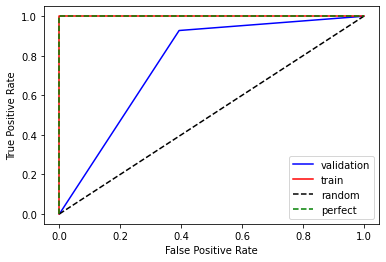

In [13]:
plot_roc_curve(y_train, y_proba_t, y_val, y_proba)

--> The model is overfitted, so we need to tune the model.

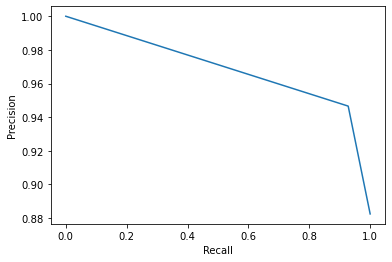

In [17]:
precision, recall, thresholds = precision_recall_curve(y_val.ravel(), y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

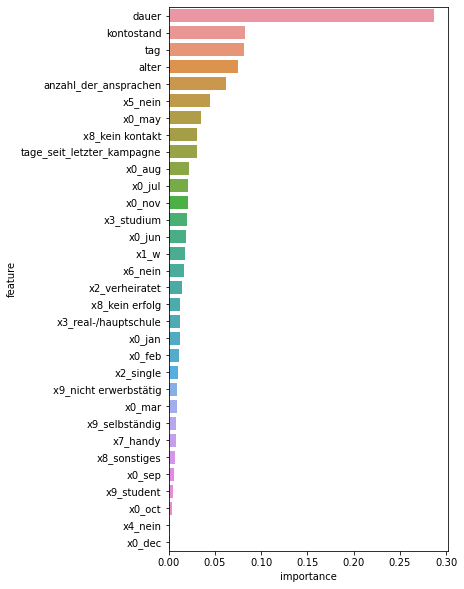

In [151]:
#Get feature importances
importances = pd.DataFrame(data = [rf_model.feature_importances_, feature_names]).transpose()
importances.rename({0: 'importance', 1: 'feature'}, axis = 1, inplace = True)
importances.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize=(5, 10))
sns.barplot(data = importances, x = 'importance', y = 'feature', );

In [192]:
#Feature Importance
#Since it is biased towards continuous or high-cardinality features, I do not use sklearn's feature importance but use a drop-column-approach. This computationally 
# more expensive but gives better results.
def dc_importance(model, X_train, y_train, X_val, y_val, feature_names):
    from tqdm import tqdm
    '''Get feature importance using a drop-column-approach: Importance is calculated based on score changes after removing the feature.
    Input: X, y as pd.DataFrames, feature_names as list'''
    #Fit model with all features
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)
    benchmark_score = roc_auc_score(y_val, y_proba[:,1]) 
    
    importances = []
    for col in tqdm(pd.DataFrame(X_train).columns):
        model.fit(pd.DataFrame(X_train).drop(col, axis = 1), y_train)
        y_proba_d = model.predict_proba(pd.DataFrame(X_val).drop(col, axis = 1))
        drop_score = roc_auc_score(y_val, y_proba_d[:,1]) 
        importances.append(benchmark_score - drop_score)
    importances_df = pd.DataFrame(data = [feature_names, rf_model.feature_importances_]).transpose()
    importances_df.rename({1: 'importance', 0: 'feature'}, axis = 1, inplace = True)
    importances_df.sort_values('importance', ascending = False, inplace = True)
    return importances_df

In [193]:
importances = dc_importance(rf_model, X_train, y_train.ravel(), X_val, y_val.ravel(), feature_names)

100%|██████████| 32/32 [29:58<00:00, 56.20s/it]


In [203]:
importances.importance = importances.importance.astype('float');

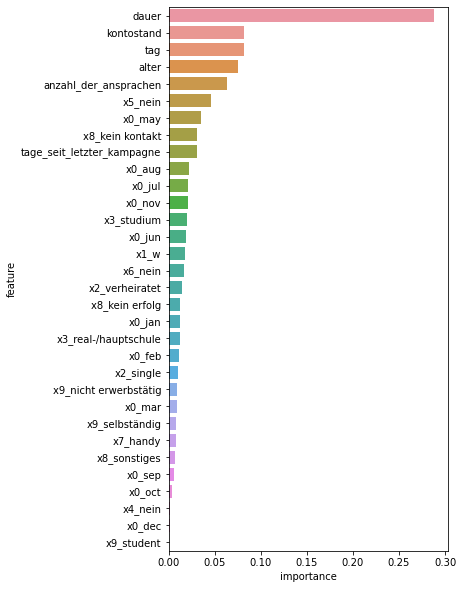

In [206]:
plt.figure(figsize=(5, 10))
sns.barplot(data = importances, x = 'importance', y = 'feature', );

In [208]:
#Grid Search
params_rf = {
    'n_estimators': list(range(1000, 2001, 100)),
    'max_depth': list(range(40, 101, 10)),
    'min_samples_split': list(range(2, 6, 2)),
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 5, 1: 1}],
    'criterion': ['gini', 'entropy']
}

TypeError: 'list' object is not callable

In [213]:
list(range(1000, 2001, 100))

TypeError: 'list' object is not callable